## ASAPool Model

In [1]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool, global_mean_pool, ASAPooling, JumpingKnowledge
import math
import numpy as np

/home/grabeda2/pyg_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Training Parameters and Model Name

In [2]:
model_name = 'model_asapool'
num_epochs = 400
learning_rate = 0.0002
batch_size = 32

### Load Data

In [3]:
data_dir = 'data_all/'
from c_PatchDataset_sparse import PatchDataset
dataset = PatchDataset(data_dir = data_dir)

In [5]:
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')

print('Example Data Sample:')
data = dataset[0]  # Get the first graph object.
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of node features: {data.num_node_features}')

Dataset: PatchDataset(23241):
Number of graphs: 23241
Example Data Sample:
Data(x=[1048, 19], edge_index=[2, 11738], edge_attr=[11738], y=0, fitness=0.0)
Number of nodes: 1048
Number of node features: 19


In [6]:
# Split into training, validation and testing dataset with fixed random seed for reproducibility

n_train = math.ceil((4/6) * len(dataset))
n_val = math.ceil((len(dataset) - n_train)/2)
n_test = len(dataset) - n_train - n_val

torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle=True)

Number of training graphs: 15494
Number of validation graphs: 3874
Number of test graphs: 3873


In [8]:
# To compute the weights for the NLLL Loss, compute the percentage of label 1 in each dataset

dataset_fraction = [0,0]

train_fraction = [0,0]
val_fraction = [0,0]
test_fraction = [0,0]

for grph in train_dataset: 
    if grph.y == 1: 
        train_fraction[1] +=1
        dataset_fraction[1] +=1 
    else: 
        train_fraction[0] +=1
        dataset_fraction[0] +=1 

for grph in val_dataset: 
    if grph.y == 1:
         val_fraction[1] +=1
         dataset_fraction[1] +=1  
    else:
         val_fraction[0] +=1
         dataset_fraction[0] +=1

for grph in test_dataset: 
    if grph.y == 1:
         test_fraction[1] +=1
         dataset_fraction[1] +=1 
    else:
         test_fraction[0] +=1
         dataset_fraction[0] +=1

print(f'Overall dataset percentage of label 1 = {dataset_fraction[1]/len(dataset)})')
print(f'Training dataset percentage of label 1 = {train_fraction} = {train_fraction[1]/len(train_dataset)}')
print(f'Validation dataset percentage of label 1 = {val_fraction} = {val_fraction[1]/len(val_dataset)}')
print(f'Test dataset percentage of label 1 = {test_fraction} = {test_fraction[1]/len(test_dataset)}')
print()
weights = torch.tensor([train_fraction[1]/train_fraction[0], 1])
print(f'Weights for Training: {weights}')

Overall dataset percentage of label 1 = 0.041005120261606645)
Training dataset percentage of label 1 = [14865, 629] = 0.040596359881244354
Validation dataset percentage of label 1 = [3698, 176] = 0.04543107898812597
Test dataset percentage of label 1 = [3725, 148] = 0.038213271365866254

Weights for Training: tensor([0.0423, 1.0000])


### Define Network

In [9]:
class GCN_ASAPool(torch.nn.Module):
    def __init__(self, in_channels, out_channels, ratio):
        super(GCN_ASAPool, self).__init__()

        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)
        self.asapool = ASAPooling(out_channels, ratio=ratio)


    def forward(self, x, edge_index, edge_weight, batch, readout):
        
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x, edge_index, edge_weight, batch, *_ = self.asapool(x, edge_index, edge_weight, batch=batch)

        readout.append((torch.cat([global_mean_pool(x, batch), global_max_pool(x, batch)], dim=1)))

        return x, edge_index, edge_weight, batch, readout


class ASAPool(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, n_classes, ratio= 0.2):
        super(ASAPool, self).__init__()

        self.gcn1 = GCN_ASAPool(in_channels, hidden_channels, ratio)
        self.gcn2 = GCN_ASAPool(hidden_channels, hidden_channels, ratio)
        self.gcn3 = GCN_ASAPool(hidden_channels, hidden_channels, ratio)
        self.gcn4 = GCN_ASAPool(hidden_channels, hidden_channels, 1)

        # Readout
        self.readout = JumpingKnowledge(mode='cat')

        # Final Classifier 
        self.lin1 = torch.nn.Linear(4 * hidden_channels * 2, hidden_channels)
        self.bns = torch.nn.BatchNorm1d(hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, n_classes)
        

    def forward(self, x, edge_index, edge_weight, batch):

        readout = []

        x, edge_index, edge_weight, batch, readout = self.gcn1(x, edge_index, edge_weight, batch, readout)
        x, edge_index, edge_weight, batch, readout = self.gcn2(x, edge_index, edge_weight, batch, readout)
        x, edge_index, edge_weight, batch, readout = self.gcn3(x, edge_index, edge_weight, batch, readout)
        x, edge_index, edge_weight, batch, readout = self.gcn4(x, edge_index, edge_weight, batch, readout)
        

        out = self.readout(readout)
        out = F.dropout(out, p=0.3, training=self.training)
        out = F.relu(self.lin1(out))
        out = self.bns(out)
        out = self.lin2(out)
        log = F.log_softmax(out, dim=-1)

        return log

In [10]:
# Function to count number of trainable parameters
def count_parameters(model, trainable=True):
    return sum(p.numel() for p in model.parameters() if p.requires_grad or not trainable)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ASAPool(in_channels=19 , hidden_channels=32, n_classes=2).to(device)
model = model.float()

criterion = torch.nn.NLLLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(output, data.y.view(-1))
        loss.backward()
        loss_all += data.y.size(0) * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    test_loss_all = 0
    correct = 0

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
        
        # Compute Accuracy
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y.view(-1)).sum().item()

        # Compute Loss
        test_loss = criterion(output, data.y.view(-1))
        test_loss_all += data.y.size(0) * test_loss.item()

    return correct / len(loader.dataset), test_loss_all / len(loader.dataset)


# Initialize data collections
#==============================================================================================================================
tr_loss = []
tr_acc = []
v_loss = []
v_acc = []

highest_val_acc = 0

# Generate txt file to collect output data
parameters = count_parameters(model)
with open(f'{model_name}_output.txt', 'w') as f:
    f.write(f'Training Data ({model_name}):\n')
    f.write(f'Number of Parameters: {parameters}\n')
    f.write(f'Learning Rate: {learning_rate}\n')
    f.write(f'Batch Size: {batch_size}\n\n')
    f.close()
#==============================================================================================================================


# Training and Validation Accuracy and Loss before Training
#==============================================================================================================================
train_acc, train_loss = test(train_loader)
tr_loss.append(train_loss)
tr_acc.append(train_acc)

val_acc, val_loss = test(val_loader)
v_loss.append(val_loss)
v_acc.append(val_acc)

printout = (f'Before Tr, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, '#Test Loss: {test_loss:.3f}, '
         f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')#, Test Acc: {test_acc:.3f}')

print(printout)

# append to outputs txt
with open(f'{model_name}_output.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()
#==============================================================================================================================


#===============================================================================================================================================
# Training
#===============================================================================================================================================
for epoch in range(1,num_epochs+1):
    
    loss = train(epoch)


    # Training and Validation Accuracy and Loss During Training
    #============================================================================================================================================
    train_acc, train_loss = test(train_loader)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)

    val_acc, val_loss = test(val_loader)
    v_loss.append(val_loss)
    v_acc.append(val_acc)

    #test_acc, test_loss = test(test_loader)
    #tst_loss.append(test_loss)
    #tst_acc.append(test_acc)

    printout = (f'Epoch {epoch:03d}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, '#Test Loss: {test_loss:.3f}, '
         f'Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}')#, Test Acc: {test_acc:.3f}')
    print(printout)

    # append to outputs txt
    with open(f'{model_name}_output.txt', 'a') as f:
        f.write(printout + '\n')
        f.close()   
    #===============================================================================================================================================


    # Save the model outputs
    #===============================================================================================================================================
    np.save(f'{model_name}_training_loss.npy', tr_loss, allow_pickle=True)
    np.save(f'{model_name}_training_accuracy.npy', tr_acc, allow_pickle=True)

    np.save(f'{model_name}_validation_loss.npy', v_loss, allow_pickle=True)
    np.save(f'{model_name}_validation_accuracy.npy', v_acc, allow_pickle=True)

    last_saved_epoch = epoch
    #===============================================================================================================================================



    # If the epoch has improved the model, save it
    new_best = False
    if val_acc >= highest_val_acc:
        new_best = True
        highest_val_acc = val_acc

    if new_best or epoch % 50 == 0:
        torch.save(model.state_dict(), f'{model_name}_state_dict_epoch{epoch}.pt')

### Evaluation

In [11]:
training_loss = np.load(f'{model_name}_training_loss.npy', allow_pickle=True)
training_accuracy = np.load(f'{model_name}_training_accuracy.npy', allow_pickle=True)

validation_loss = np.load(f'{model_name}_validation_loss.npy', allow_pickle=True)
validation_accuracy = np.load(f'{model_name}_validation_accuracy.npy', allow_pickle=True)

In [57]:
cut_epoch = len(training_loss)
cut_epoch

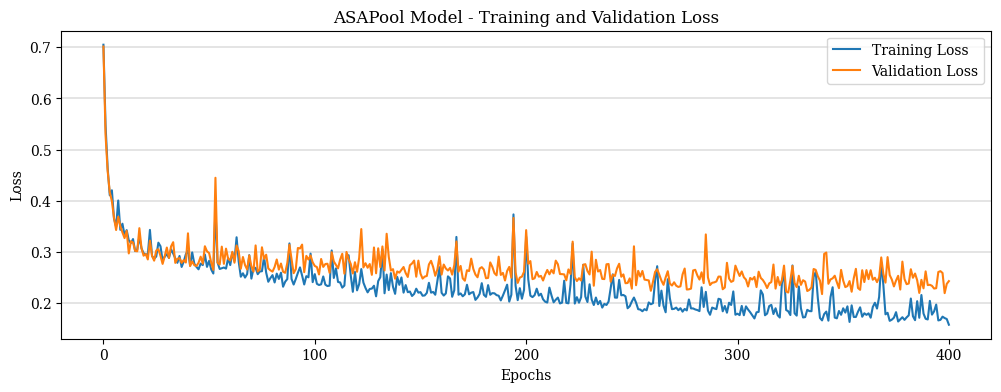

In [58]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

#Manage fonts
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

fig = plt.figure(figsize = (12,4))

# Generate a sequence of integers to represent the epoch numbers
epochs = range(0, cut_epoch)
 
# Plot and label the training and validation loss values
ax = plt.plot(epochs, training_loss[0:cut_epoch], label='Training Loss')
ax2 = plt.plot(epochs, validation_loss[0:cut_epoch], label='Validation Loss')
#plt.plot(epochs, test_loss[0:cut_epoch], label='Test Loss')
 
# Add all the text elements
plt.title('ASAPool Model - Training and Validation Loss', **hfont)
plt.xlabel('Epochs', **hfont)
plt.ylabel('Loss', **hfont)

# Set the tick locations
plt.xticks(np.arange(0, cut_epoch, 100), **hfont)
plt.yticks(**hfont)
 
# Display the plot
plt.legend(loc='upper right', prop = font)
plt.grid(axis = 'y', color = 'gray', linewidth = 0.3)
plt.rcParams['savefig.dpi']=300
plt.savefig(f'{model_name}_plot_loss.png')
plt.show()

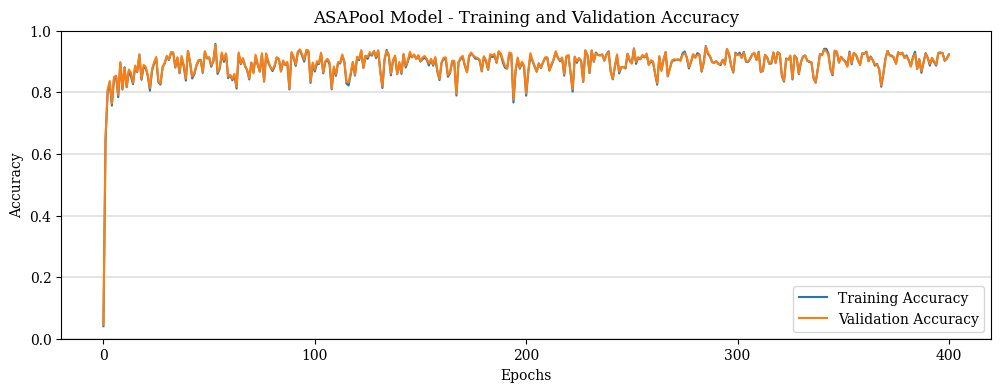

In [59]:
import matplotlib.pyplot as plt

#Manage fonts
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

fig = plt.figure(figsize = (12,4))

# Generate a sequence of integers to represent the epoch numbers
epochs = range(0, cut_epoch)
 
# Plot and label the training and validation loss values
plt.plot(epochs, training_accuracy[0:cut_epoch], label='Training Accuracy')
plt.plot(epochs, validation_accuracy[0:cut_epoch], label='Validation Accuracy')
#plt.plot(epochs, test_accuracy[0:cut_epoch], label='Test Accuracy')

# Add all the text elements
plt.title('ASAPool Model - Training and Validation Accuracy', **hfont)
plt.xlabel('Epochs', **hfont)
plt.ylabel('Accuracy', **hfont)

# Set the tick locations
plt.xticks(np.arange(0, cut_epoch, 100), **hfont)
plt.yticks(**hfont)
plt.ylim(0,1)

# Display the plot
plt.legend(loc='lower right', prop = font)
plt.grid(axis = 'y', color = 'gray', linewidth = 0.3)
plt.rcParams['savefig.dpi']=300
plt.savefig(f'{model_name}_plot_accuracy.png')
plt.show()

### Testing the Model

In [16]:
#Determine which state_dict to use for testing on the test dataset
state_dict_name = 'model_asapool_state_dict_epoch285.pt'
inference_loader = DataLoader(dataset = test_dataset, batch_size=16, shuffle=True)

In [17]:
# Initialize model with state_dict parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ASAPool(in_channels=19 , hidden_channels=32, n_classes=2).to(device)
model.load_state_dict(torch.load(state_dict_name))
model.eval()

ASAPool(
  (gcn1): GCN_ASAPool(
    (conv1): GCNConv(19, 32)
    (conv2): GCNConv(32, 32)
    (asapool): ASAPooling(32, ratio=0.2)
  )
  (gcn2): GCN_ASAPool(
    (conv1): GCNConv(32, 32)
    (conv2): GCNConv(32, 32)
    (asapool): ASAPooling(32, ratio=0.2)
  )
  (gcn3): GCN_ASAPool(
    (conv1): GCNConv(32, 32)
    (conv2): GCNConv(32, 32)
    (asapool): ASAPooling(32, ratio=0.2)
  )
  (gcn4): GCN_ASAPool(
    (conv1): GCNConv(32, 32)
    (conv2): GCNConv(32, 32)
    (asapool): ASAPooling(32, ratio=1)
  )
  (readout): JumpingKnowledge(cat)
  (lin1): Linear(in_features=256, out_features=32, bias=True)
  (bns): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [18]:
def inference_test(loader):
    model.eval()

    inf_loss_all = 0
    correct = 0

    predictions=[]
    ground_truth = []
    fitnesses = []
    

    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
        
        # Compute Accuracy
        pred = output.max(dim=1)[1]

        predictions = predictions + pred.tolist()
        ground_truth = ground_truth + data.y.view(-1).tolist()
        fitnesses = fitnesses + data.fitness.tolist()
        
        correct += pred.eq(data.y.view(-1)).sum().item()

        # Compute Loss
        test_loss = F.nll_loss(output, data.y.view(-1))
        inf_loss_all += data.y.size(0) * test_loss.item()

    return correct / len(loader.dataset), inf_loss_all / len(loader.dataset), predictions, ground_truth, fitnesses

In [19]:
inf_acc, inf_loss, predictions, ground_truth, fitnesses = inference_test(inference_loader)

print(inf_acc)
print(inf_loss)

0.9473276529821844
0.1294200703157355


### Plots

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.font_manager as font_manager
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D

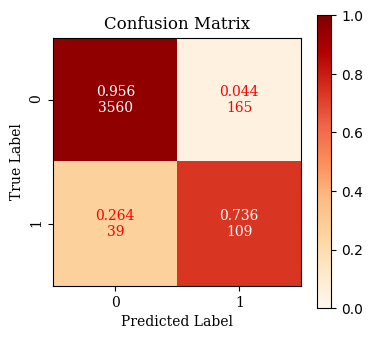

In [28]:
# Plot Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ground_truth, predictions, labels=[0,1])
cm_norm = confusion_matrix(ground_truth, predictions, labels=[0,1], normalize='true')

#Manage fonts
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

classes = [0,1]
fig, ax = plt.subplots(figsize=(4,3.8))
cb = ax.imshow(cm_norm, cmap='OrRd', vmin = 0, vmax = 1)

plt.xticks(range(len(classes)), classes, **hfont)
plt.yticks(range(len(classes)), classes, rotation = 90, **hfont)

for i in range(len(classes)):
    for j in range(len(classes)):
        color='red' if cm_norm[j,i] < 0.5 else 'white'
        ax.annotate(f'{cm_norm[j,i]:.3f}\n{cm[j,i]}', (i,j), 
                    color=color, va='center', ha='center', **hfont)


plt.ylabel('True Label', **hfont)
plt.xlabel('Predicted Label', **hfont)
plt.title('Confusion Matrix', **hfont)

plt.colorbar(cb, ax=ax)

plt.rcParams['savefig.dpi']=300
plt.savefig(f'{model_name}_plot_confusion_matrix.png', bbox_inches = 'tight')

plt.show()

In [29]:
# Compute performance metrics

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
specificity

print('Accuracy: %.3f' % accuracy_score(ground_truth, predictions))
print('Precision: %.3f' % precision_score(ground_truth, predictions))
print('Recall: %.3f' % recall_score(ground_truth, predictions))
print('Specificity: %.3f' % specificity)
print('F1 Score: %.3f' % f1_score(ground_truth, predictions))

Accuracy: 0.947
Precision: 0.398
Recall: 0.736
Specificity: 0.956
F1 Score: 0.517


### Calculations for Assignment matrix

In [30]:
fitness_bins_correct = []
fitness_bins_false = []

for index, fit in enumerate(fitnesses):
    if ground_truth[index] == predictions[index]:
        fitness_bins_correct.append(fit)

    else:
        fitness_bins_false.append(fit)


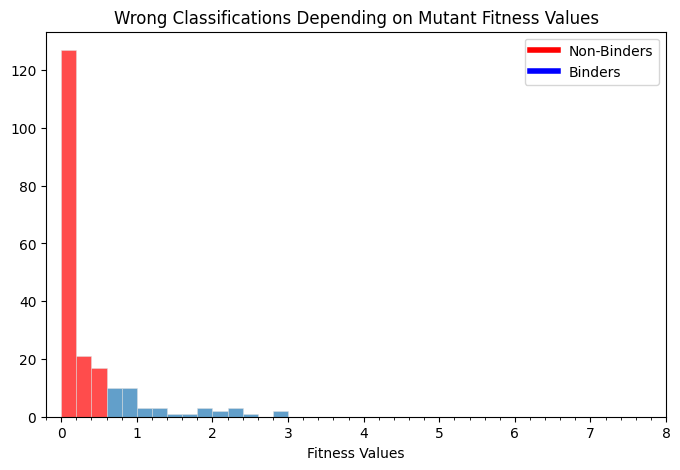

In [31]:
# Plot wrong classifications per fitness bin 

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

fig, ax2 = plt.subplots(1,1, sharex=True, figsize=(8,5))

x_lim_down = 0
x_lim_up = 8
bin_size = 0.2
bins = np.arange(x_lim_down, x_lim_up+0.1, bin_size)

n, bins, patches = ax2.hist(fitness_bins_false, bins=bins, linewidth=0.5, alpha=0.7, edgecolor='#e0e0e0')
false_bins = n

patches[0].set_fc('red')
patches[1].set_fc('red')
patches[2].set_fc('red')

ax2.set_xlim(-0.2, 8)
ax2.legend(custom_lines, ['Non-Binders', 'Binders'])
ax2.xaxis.set_minor_locator(MultipleLocator(0.2))

ax2.set_title('Wrong Classifications Depending on Mutant Fitness Values')
plt.xlabel('Fitness Values', fontsize=10)
plt.show()

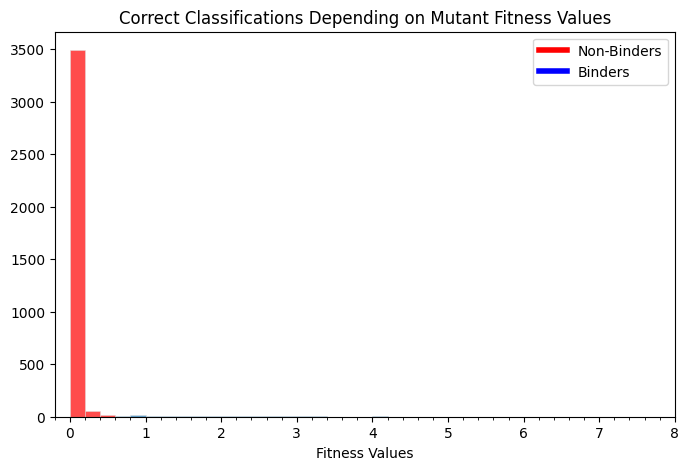

In [44]:
# Plot Correct Classifications per fitness bin

custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

fig, ax2 = plt.subplots(1,1, sharex=True, figsize=(8,5))

x_lim_down = 0
x_lim_up = 8
bin_size = 0.2
bins = np.arange(x_lim_down, x_lim_up+0.1, bin_size)

n, bins, patches = ax2.hist(fitness_bins_correct, bins=bins, linewidth=0.5, alpha=0.7, edgecolor='#e0e0e0')
correct_bins = n

patches[0].set_fc('red')
patches[1].set_fc('red')
patches[2].set_fc('red')

ax2.set_xlim(-0.2, 8)
ax2.legend(custom_lines, ['Non-Binders', 'Binders'])
ax2.xaxis.set_minor_locator(MultipleLocator(0.2))

ax2.set_title('Correct Classifications Depending on Mutant Fitness Values')
plt.xlabel('Fitness Values', fontsize=10)
plt.show()

In [45]:
total_bins = correct_bins + false_bins
ratio_bins = correct_bins / total_bins
ratio_bins


/tmp/ipykernel_136415/649716363.py:2: RuntimeWarning: invalid value encountered in divide
  ratio_bins = correct_bins / total_bins


array([0.96488803, 0.72      , 0.48484848, 0.52380952, 0.56521739,
       0.7       , 0.78571429, 0.88888889, 0.90909091, 0.75      ,
       0.77777778, 0.5       , 0.8       , 1.        , 0.66666667,
       1.        , 1.        , 1.        ,        nan, 1.        ,
       1.        ,        nan,        nan,        nan,        nan,
       1.        , 1.        , 1.        ,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [46]:
assign_matrix = np.array([correct_bins.tolist(), false_bins.tolist()], dtype=int)
assign_matrix

array([[3490,   54,   16,   11,   13,    7,   11,    8,   10,    9,    7,
           3,    4,    7,    4,    3,    4,    1,    0,    1,    3,    0,
           0,    0,    0,    1,    1,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 127,   21,   17,   10,   10,    3,    3,    1,    1,    3,    2,
           3,    1,    0,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [47]:
sum_matrix = np.sum(assign_matrix, 0).tolist()

In [48]:
percentages = np.zeros((2, assign_matrix.shape[1]))
for column in range(assign_matrix.shape[1]):
    for row in range(assign_matrix.shape[0]):
        percentages[row, column] = assign_matrix[row, column] / sum_matrix[column]

percentages


/tmp/ipykernel_136415/3115980556.py:4: RuntimeWarning: invalid value encountered in long_scalars
  percentages[row, column] = assign_matrix[row, column] / sum_matrix[column]


array([[0.96488803, 0.72      , 0.48484848, 0.52380952, 0.56521739,
        0.7       , 0.78571429, 0.88888889, 0.90909091, 0.75      ,
        0.77777778, 0.5       , 0.8       , 1.        , 0.66666667,
        1.        , 1.        , 1.        ,        nan, 1.        ,
        1.        ,        nan,        nan,        nan,        nan,
        1.        , 1.        , 1.        ,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [0.03511197, 0.28      , 0.51515152, 0.47619048, 0.43478261,
        0.3       , 0.21428571, 0.11111111, 0.09090909, 0.25      ,
        0.22222222, 0.5       , 0.2       , 0.        , 0.33333333,
        0.        , 0.        , 0.        ,        nan, 0.        ,
        0.        ,        nan,        nan,        nan,        nan,
        0.        , 0.        , 0.        ,        nan,        nan,
               nan,        nan,        nan,    

In [49]:
# Cut off some of the last nan's
percentages = percentages[:, 0:28]
percentages = np.around(percentages, 3)
percentages

array([[0.965, 0.72 , 0.485, 0.524, 0.565, 0.7  , 0.786, 0.889, 0.909,
        0.75 , 0.778, 0.5  , 0.8  , 1.   , 0.667, 1.   , 1.   , 1.   ,
          nan, 1.   , 1.   ,   nan,   nan,   nan,   nan, 1.   , 1.   ,
        1.   ],
       [0.035, 0.28 , 0.515, 0.476, 0.435, 0.3  , 0.214, 0.111, 0.091,
        0.25 , 0.222, 0.5  , 0.2  , 0.   , 0.333, 0.   , 0.   , 0.   ,
          nan, 0.   , 0.   ,   nan,   nan,   nan,   nan, 0.   , 0.   ,
        0.   ]])

In [50]:
bins = bins[0:28]
bins= np.around(bins, 1)
bins

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
       5.2, 5.4])

### Output

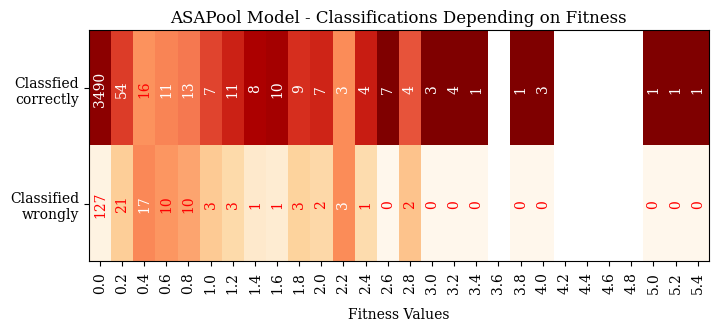

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.font_manager as font_manager


cm = confusion_matrix(ground_truth, predictions, labels=[0,1])
cm_norm = confusion_matrix(ground_truth, predictions, labels=[0,1], normalize='true')

#Manage fonts
hfont = {'fontname':'serif'}
font = font_manager.FontProperties(family='serif',
                                   weight='normal',
                                   style='normal')

classes = ['Classfied\ncorrectly','Classified\nwrongly']
fig, ax = plt.subplots(figsize=(8,3))
cb = ax.imshow(percentages[0:30], cmap='OrRd', aspect = 'auto')

plt.xticks(range(len(bins)),bins, rotation = 90, **hfont)
plt.yticks(range(len(classes)), classes, **hfont)

for i in range(len(classes)):
    for j in range(len(bins)):
        color='red' if percentages[i,j] < 0.5 else 'white'
        ax.annotate(f'{assign_matrix[i,j]}', (j,i), 
                    color=color, va='center', ha='center', rotation=90 ,**hfont)


plt.xlabel('Fitness Values', labelpad = 10, **hfont)
plt.title('ASAPool Model - Classifications Depending on Fitness', **hfont)

#plt.colorbar(cb, ax=ax, location='top', orientation = 'horizontal', fraction = 0.1 )

plt.rcParams['savefig.dpi']=300
plt.savefig(f'{model_name}_plot_assignment_matrix.png', bbox_inches = 'tight')

plt.show()